> This notebook analyses how the initial state of charge (SOC_0) affects SEI growth during discharge across PyBaMM zero-dimensional SEI models: ("reaction limited","solvent-diffusion limited", "ec reaction limited", "electron-migration limited",   "interstitial-diffusion limited",  "VonKolzenberg2020") \
> We test nine initial SOC values (0.1 to 0.9) and find:
> - Higher initial SOC leads to more SEI growth across all models, due to longer discharge times.
> - C-rate does not affect SEI growth patterns, except in the solvent reaction model [Yang et al. (2017)](https://www.sciencedirect.com/science/article/abs/pii/S0378775317307619).
> - When discharge times for all SOC_0 values are same (i.e. different C-rate), each model shows distinct behaviour. 


Internal t = 481.577 and h = 2.19032e-14 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 2.19032e-14 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 1.36895e-14 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 1.36895e-14 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 5.34747e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 5.34747e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 3.34217e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 3.34217e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 481.577 and h = 5.22214e-17 are such that t + h = t on the 

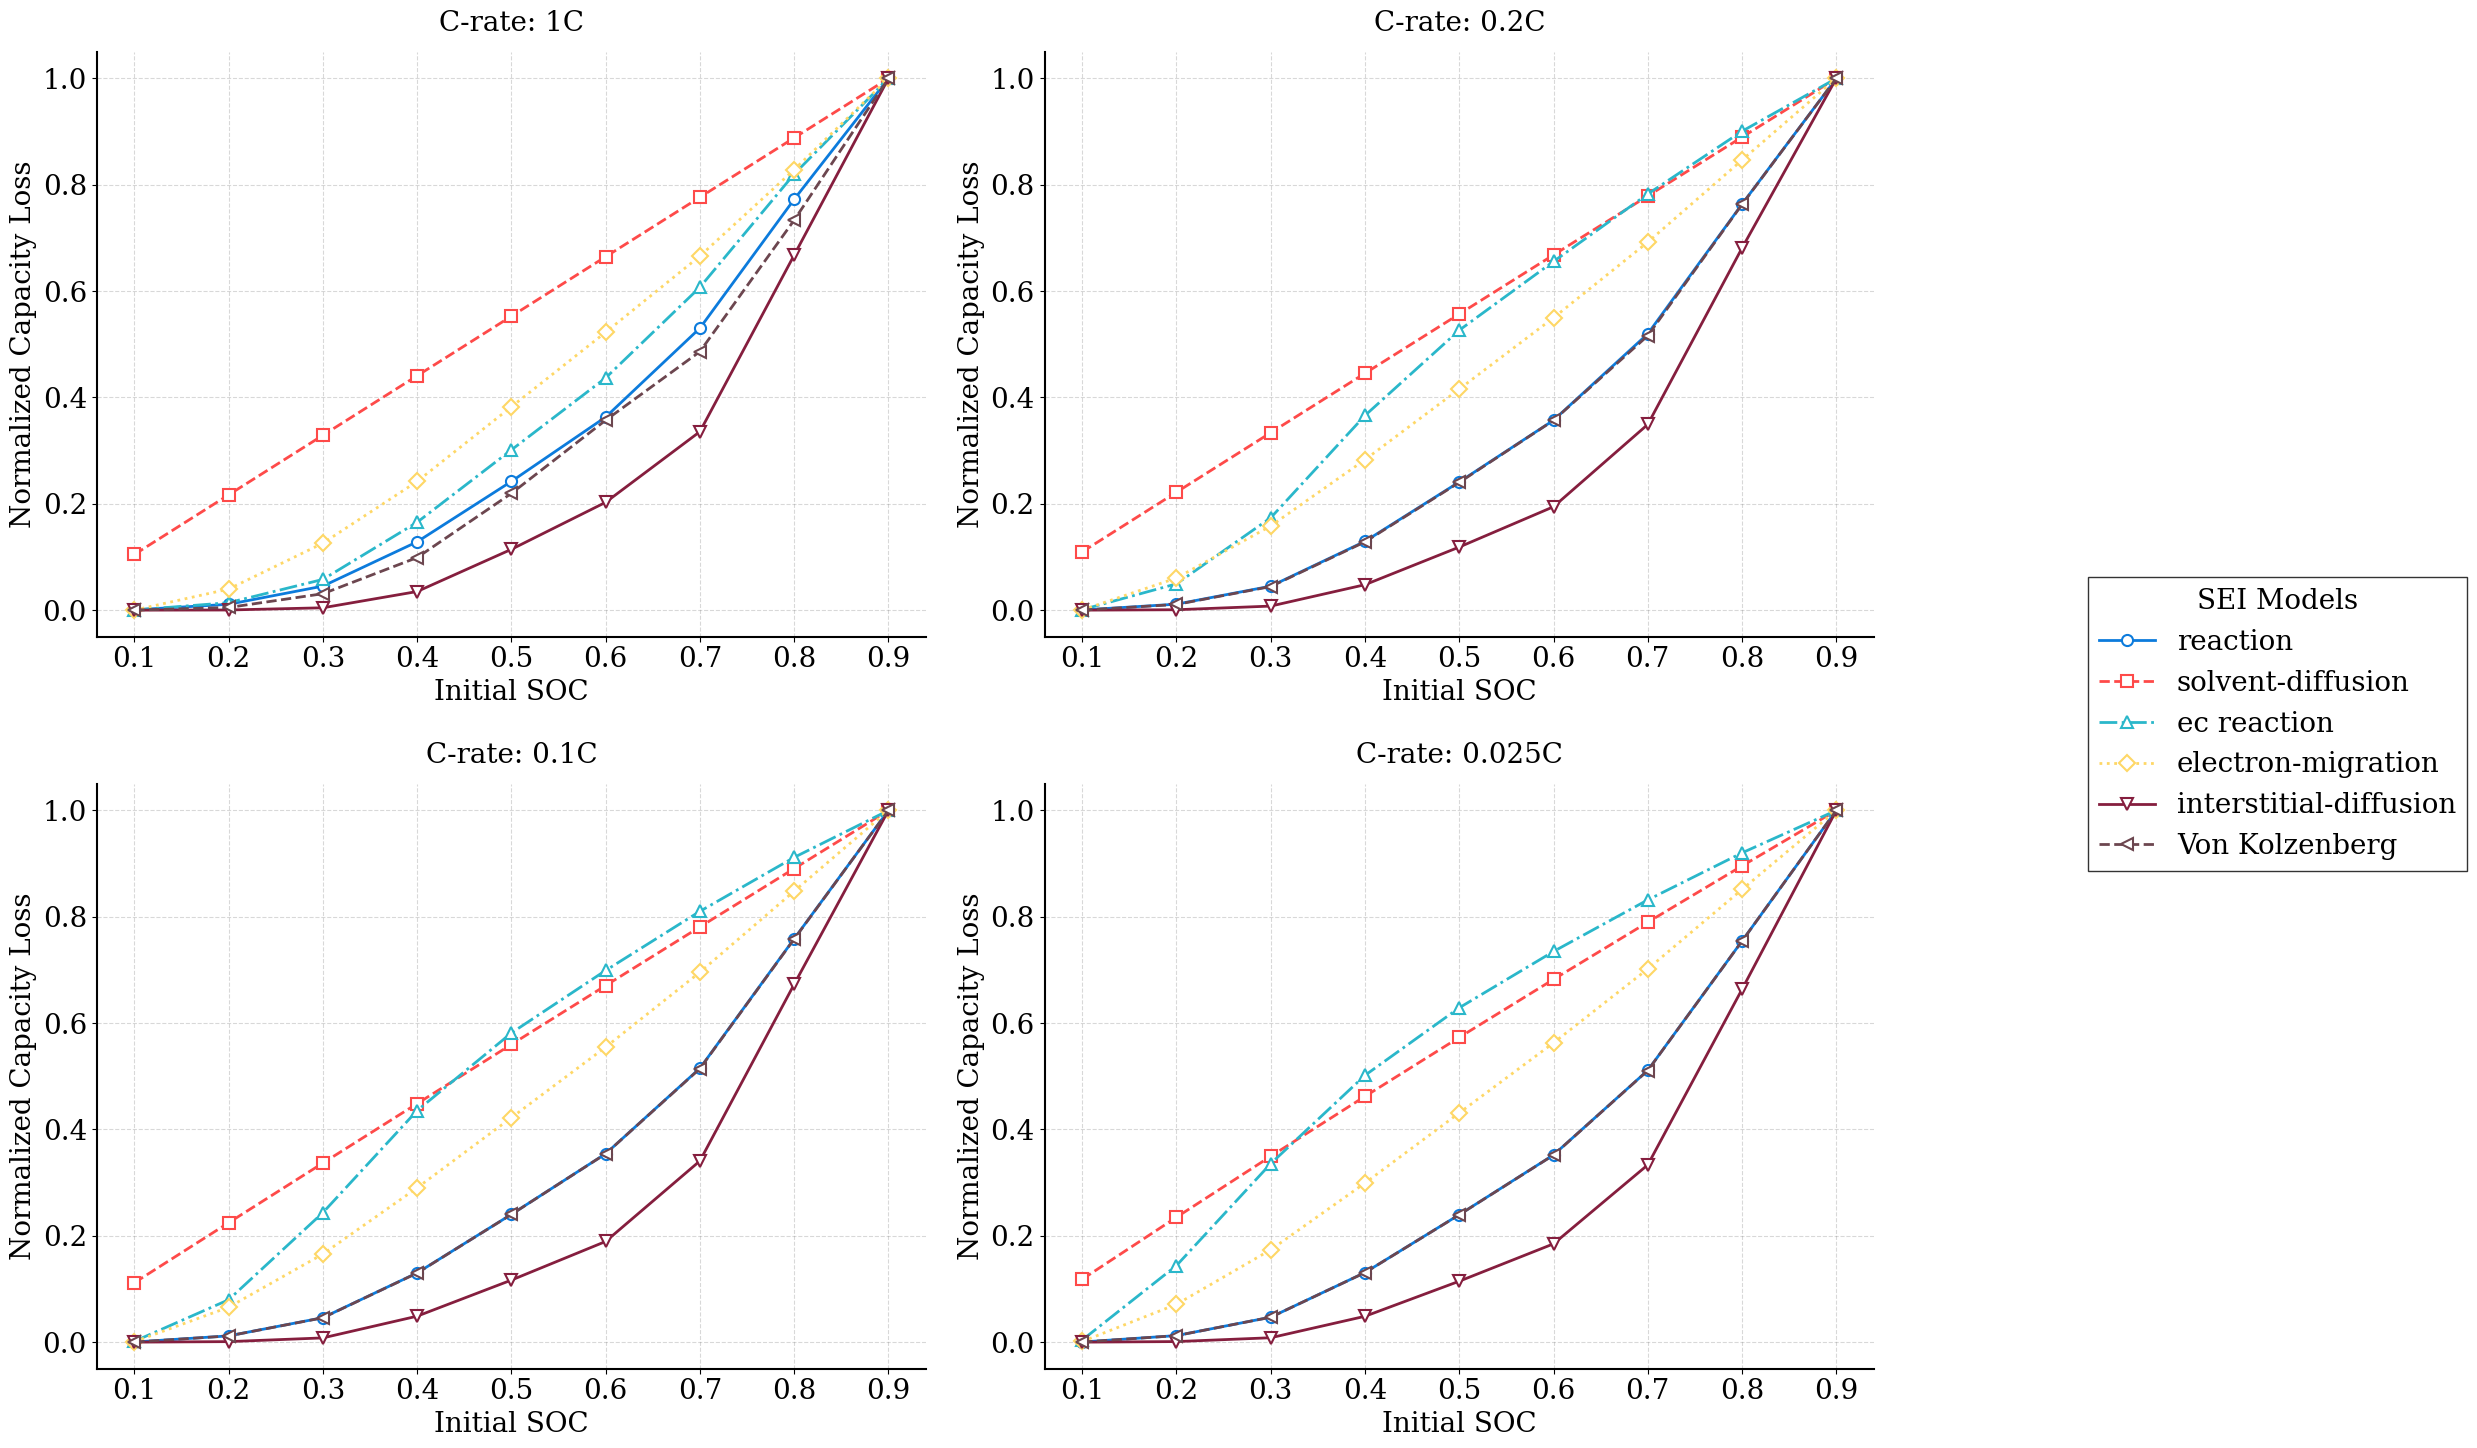

In [2]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

plt.rcParams.update({
    'font.size': 24,
    'font.family': 'serif',
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
    'legend.fontsize': 16,
    'axes.linewidth': 1.5,
    'grid.color': 'gray',
    'grid.linestyle': '--',
    'grid.alpha': 0.3,
    'lines.markersize': 8,
    'lines.linewidth': 2.0,
})

# Setup parameters
no_cycles = 1
soc_0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_c_rates = [1, 1/5, 1/10, 1/40]

# Define SEI models
sei_options = [
    "reaction limited",
    "solvent-diffusion limited",
    "ec reaction limited",
    "electron-migration limited",
    "interstitial-diffusion limited",
    "VonKolzenberg2020"
]

# Professional color scheme
colors = ['#0C7BDC', '#FE4A49', '#2AB7CA', '#FED766', '#851E3E', '#6C464F']
markers = ['o', 's', '^', 'D', 'v', '<']
line_styles = ['-', '--', '-.', ':', '-', '--']

# Create 2x2 subplot figure with wider aspect ratio
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()

# Set up model parameters
param = pybamm.ParameterValues("Chen2020")
param.update({
    'Initial SEI thickness [m]': 5e-9,
    'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
    'Tunneling distance for electrons [m]': 5,
    'Tunneling barrier factor [m-1]': 1/2.0e-9,
}, check_already_exists=False)

# Loop through different C-rates
for rate_idx, c_rate in enumerate(base_c_rates):
    # Create experiment for current C-rate
    exp = pybamm.Experiment([(f"Discharge at {c_rate}C until 2.5 V",)] * no_cycles)
    
    # Create and solve models for each SEI option
    for model_idx, sei_option in enumerate(sei_options):
        model = pybamm.lithium_ion.SPM({
            "particle": "uniform profile",
            "SEI porosity change": "false",
            "SEI": sei_option
        })
        
        sim = pybamm.Simulation(model, parameter_values=param, experiment=exp)
        
        # Solve for each initial SOC
        Q_sei = []
        for soc in soc_0:
            sol = sim.solve(initial_soc=soc)
            Q_sei.append(np.max(sol['Total capacity lost to side reactions [A.h]'].entries))
        
        Q_sei_normalized = np.array(Q_sei) / np.max(Q_sei)
        
        # Create label
        label = sei_option.replace(" limited", "").replace("VonKolzenberg2020", "Von Kolzenberg")
        if rate_idx == 0:  # Only include label for first subplot
            plot_label = label
        else:
            plot_label = None
        # Plot with enhanced styling
        axes[rate_idx].plot(soc_0, Q_sei_normalized, 
                          color=colors[model_idx],
                          label=plot_label,
                          marker=markers[model_idx],
                          linestyle=line_styles[model_idx],
                          markerfacecolor='white',
                          markeredgewidth=1.5,
                          markersize=8)
        
        # Customize each subplot with larger fonts
        axes[rate_idx].set_xlabel('Initial SOC', fontsize=20)
        axes[rate_idx].set_ylabel('Normalized Capacity Loss', fontsize=20)
        axes[rate_idx].grid(True, alpha=0.3)
        axes[rate_idx].set_title(f'C-rate: {c_rate}C', fontsize=20, pad=15)
        axes[rate_idx].spines['top'].set_visible(False)
        axes[rate_idx].spines['right'].set_visible(False)
        axes[rate_idx].tick_params(axis='both', which='major', labelsize=20)

# Add legend to the right side of the figure
fig.legend(bbox_to_anchor=(1.05, 0.5),
          loc='center left',
          title='SEI Models',
          frameon=True,
          edgecolor='black',
          fancybox=False,
          fontsize=20,
          title_fontsize=20)


plt.tight_layout()
plt.subplots_adjust(right=0.95)
plt.show()

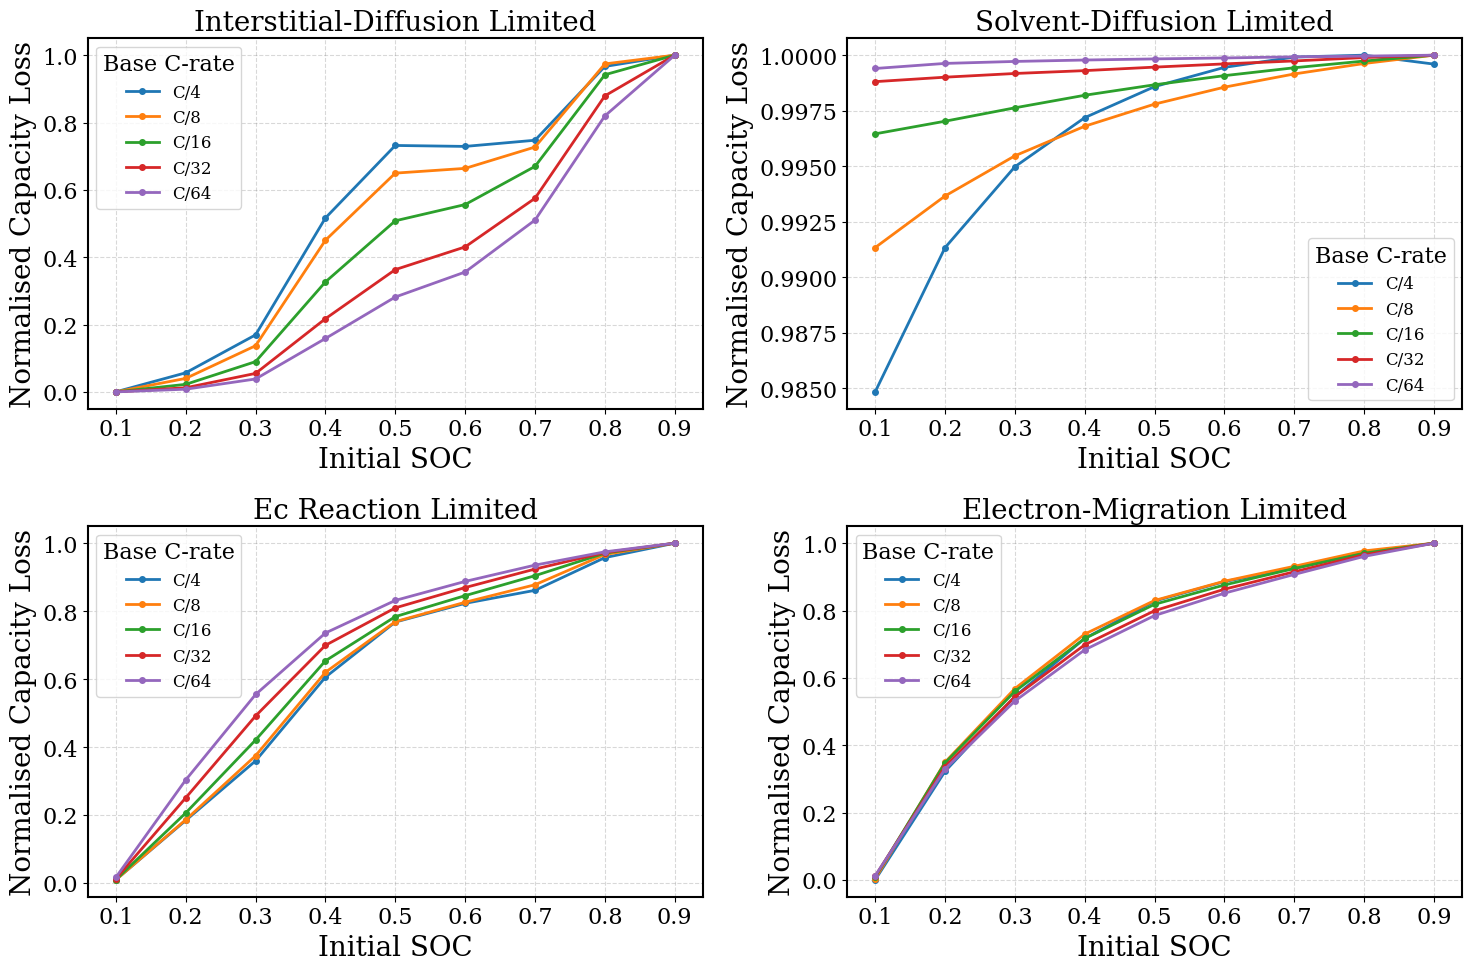

In [3]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt

# Setup parameters
no_cycles = 1
soc_0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
base_c_rates = [1/4, 1/8, 1/16, 1/32, 1/64]

# Define the four SEI options
sei_options = [
    "interstitial-diffusion limited",
    "solvent-diffusion limited",
    "ec reaction limited",
    "electron-migration limited",
]

# Create figure with subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Set font sizes
plt.rc('font', size=16)
plt.rc('axes', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

# Professional color scheme
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

# Loop through each SEI option
for subplot_idx, sei_option in enumerate(sei_options):
    ax = axes[subplot_idx]
    
    # Store results for each base C-rate
    for rate_idx, base_c_rate in enumerate(base_c_rates):
        # Calculate proportional C-rates
        c_rates = [(soc/soc_0[0]) * base_c_rate for soc in soc_0]
        
        # Create experiments
        experiments = []
        for c_rate in c_rates:
            exp = pybamm.Experiment(
                [(f"Discharge at {c_rate}C until 2.5 V",)] * no_cycles
            )
            experiments.append(exp)
        
        # Set up model parameters
        param = pybamm.ParameterValues("Chen2020")
        param.update({
            'Initial SEI thickness [m]': 5e-9,
            'SEI lithium ion conductivity [S.m-1]': 1.0e-7,
            'Tunneling distance for electrons [m]': 0,
        }, check_already_exists=False)
        
        # Create model with current SEI option
        models = [pybamm.lithium_ion.SPM({
            "SEI porosity change": "false",
            "SEI": sei_option
        })]
        
        # Create and solve simulations
        sims = []
        for exp in experiments:
            sims.extend([pybamm.Simulation(model, parameter_values=param,
                                      experiment=exp) for model in models])
        sols = [sim.solve(initial_soc=soc) for sim, soc in zip(sims, soc_0)]
        
        # Extract and normalize capacity loss results
        Q_sei = []
        for sol in sols:
            Q_sei.append(np.max(sol['Total capacity lost to side reactions [A.h]'].entries))
        Q_sei_normalized = np.array(Q_sei) / np.max(Q_sei)
        
        # Plot normalized capacity loss
        label = f'C/{1/base_c_rate:.0f}'
        ax.plot(soc_0, Q_sei_normalized, 'o-', color=colors[rate_idx],
                label=label, linewidth=2, markersize=4)
    
    # Customize subplot
    ax.set_xlabel('Initial SOC')
    ax.set_ylabel('Normalised Capacity Loss')
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.set_title(f'{sei_option.title()}')
    ax.legend(title='Base C-rate', fontsize=12)

    

plt.tight_layout()
plt.savefig('sei_models_comparison.png', bbox_inches='tight', dpi=300)